# Capstone Project – Forecasting Bitcoin Transaction Fees
#### In Partnership with Trilemma Foundation

## Summary

This notebook presents the comprehensive workflows and core insights from our capstone project. Our goal was to develop predictive models that help users anticipate short-term Bitcoin transaction fee spikes using mempool and blockchain network data. We evaluated multiple models, compared their strengths and limitations, and highlighted key findings to support smarter transaction timing.

## Notebook Structure

I. **Introduction: Motivation, Problem, and Solution**  
   Why forecasting transaction fees matters, and what questions we aim to answer.

II. **Data Overview & Exploratory Analysis**  
   Mempool structure, feature highlights, and time series patterns.

III. **Forecast Models**  
   Introduce and compare the trade-offs of six methods tried (HWES, SARIMA, XGBoost, Prophet, DeepAR, TFT).

Iv. **Performance Evaluation**  
   Key evaluation metrics and forecast comparison plots of all models on the final 24-hour test set.

V. **Final Insights & Future Work**  
   Takeaways, model limitations, and possible extensions beyond the capstone.


## I. Introduction: Motivation, Problem, and Solution

Bitcoin transaction fees are notoriously volatile and event-driven, with single-day spikes exceeding $78 million and annual costs reaching billions. Yet most tools offer only short-horizon, rule-based forecasts for the next few blocks—far from enough for users or developers needing cost-aware planning.

Our project addresses this gap by forecasting transaction fees—specifically the `fastestFee` tier, which reflects the rate needed for near-immediate confirmation—up to 24 hours in advance. We aim to identify periods of extreme volatility and provide actionable guidance on fee magnitudes within those windows.

We experimented with a wide range of models, from classical time series (SARIMA, HWES) to machine learning (XGBoost) and deep learning (Temporal Fusion Transformer). While traditional models captured general trends, they struggled with sharp jumps. TFT achieved the best performance, improving RMSE and a custom volatility-sensitive loss by 25–35%.

The result is a modular, reproducible system that combines clear analysis with extensible pipelines—offering a practical foundation for longer-horizon fee forecasting in the Bitcoin ecosystem.

## II. Exploratory Data Analysis (EDA)

We begin with a long-term historical analysis of Bitcoin fee trends using 15 years of daily metrics (see Subsection 1). This contextual view helps assess the volatility regime and test assumptions about fee spike behavior.

The remainder of this section draws on a high-resolution dataset provided by our partner for this project, capturing mempool activity, transaction volume, block composition, and other on-chain metrics at 5-minute intervals over two months (March - May 2025). Subsections 2–8 explore this data in detail to inform feature selection, preprocessing strategies, and model architecture choices.

> **Note:** For a more detailed walkthrough of the data exploration process, please refer to the companion notebook: [data_spec.ipynb](data_spec.ipynb).

### 1. 15 Years of Historical Fee Analysis (Coin Metrics)

To contextualize the short-term fee forecasting task, we analyzed over 15 years of daily Bitcoin fee data (2009–2025) from the [Coin Metrics dataset](https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv).

![Historical Fees](../results/plots/coinmetrics_fees.png)

This macro-level review revealed strong right-skew in fee distributions and recurring, irregular spikes in transaction costs. By flagging local fee surges (95th percentile within each year), we examined their frequency and timing, then assessed whether spike arrivals followed a memoryless Poisson process.

![Fees Inter-Spike Interval Distribution](../results/plots/coinmetrics_interspike_dist.png)

Inter-spike intervals showed heavy skew and failed the Kolmogorov–Smirnov test for exponentiality, indicating that spikes do not arrive randomly or independently over time. Instead, they cluster irregularly, likely driven by dynamic market conditions. This finding supports the need for forecasting models that incorporate temporal structure—beyond simple memoryless baselines—to capture bursty, event-driven fee behavior more effectively.

> **Note:** Code for the 15-year historical fee plots above can be found in **Section I: Historical Fee Analysis (2009 - 20225)** of [data_spec.ipynb](data_spec.ipynb). For all subsequent plots related to our project’s main dataset, the corresponding code is available in the script: [EDA.py](../scripts/EDA.py)

### 2. Overview of Fee Volatility

Now turning to the dataset used in this project, the `fastestFee` series displays sharp volatility, with sporadic spikes well above typical values. This behavior motivated our focus on metrics that are sensitive to volatility and spike detection.

![Fee Overview](../results/plots/fee_peaks_summary.png)

### 3. Distribution of Target `fastestFee`

The distribution of Fastest Fee is highly skewed toward 1–3 sats/vByte. To improve model stability and better meet statistical assumptions, we applied log transformations where appropriate to reduce skewness and make the data more suitable for forecasting.

![Feature Distributions](../results/plots/fee_distribution.png)

### 4. Seasonality and Trend

We decomposed the target series into trend, seasonality, and residuals. Daily cycles are clearly visible, aligning with Bitcoin block times and global trading activity. A multiplicative decomposition provided a better fit, reflecting how fee levels scale with overall network demand.

![Seasonality](../results/plots/decomposition_multiplicative.png)

### 5. Stationarity Check

We applied the Augmented Dickey-Fuller (ADF) test to verify whether the `fastestFee` series is stationary—an essential assumption for classical time series models like SARIMA. 

- **Null Hypothesis $H_0$**: The data is non-stationary.
- **Test Result**: We reject $H_0$ at << 1% significance level both globally (full series) and locally (weekly splits).
- **Conclusion**: The series is stationary and no differencing is required for modeling.

This validation allows us to directly apply autoregressive models without transformation for stationarity.

### 6. Autocorrelation & Lag Analysis

To assess short-term temporal dependencies, we analyzed autocorrelation (ACF) and partial autocorrelation (PACF) of the fastestFee series. Strong correlations within the first few lags validate the presence of autoregressive structure and short-term dependencies, motivating the use of models like SARIMA that can explicitly leverage lagged information.

![ACF & PACF](../results/plots/acf_pacf_plot.png)


### 7. Optimal Resampling Frequency

Given the volatility of the original 5-minute series, we evaluated different resampling intervals to balance signal fidelity and noise reduction. Using decay ratio curves, we found that a 15-minute frequency preserved the strongest AR(1)-like structure, offering more stable short-term dependencies for downstream modeling. All models in this study use this resolution.

![Decay Ratio](../results/plots/optimal_interval.png)

### 8. Correlation Analysis

To illustrate dependencies beyond autoregression, we examined pairwise correlations between fastestFee and other network-level features. Fee-related congestion signals such as Next Block Total Fee, # of Transactions, and Mempool Count showed high correlation with the target variable, indicating they capture meaningful network dynamics. These findings justify the inclusion of auxiliary features in tree-based and deep learning models to improve forecast accuracy.

![Correlation Heatmap](../results/plots/spearman_correlation.png)

## III. Forecast Models: Mechanisms and Tradeoffs

To forecast Bitcoin transaction fees over longer 24-hour horizon, we explored a range of modeling paradigms, each with distinct assumptions, strengths, and limitations. Our approach was intentionally progressive: we began with simple statistical baselines and gradually introduced models with greater flexibility, capacity for feature integration, and ability to adapt to volatile dynamics. This section summarizes the key mechanisms behind each model and compares their tradeoffs.

The below diagram illustrates our progressive modeling approach by showing how each model builds on the previous one, incorporating more complexity, feature integration, and temporal learning capabilities:  

![Model Progression](../img/model_progression.png)

### 1. Baseline: Constant Forecast

**Global Median (Dummy Model)**  
- **Purpose**: Establish a performance floor for all future models.  
- **Mechanism**: Always predicts the historical median fee.  
- **Tradeoffs**: Completely static; ignores temporal and contextual information.

### 2. Classical Time Series Models

**Holt-Winters Exponential Smoothing (HWES)**  
- **Mechanism**: Decomposes the series into level, trend, and seasonality components using exponential smoothing.  
- **Strengths**: Interpretable and efficient; suitable for capturing daily periodicity.  
- **Limitations**: Cannot handle external variables or irregular events like sudden fee spikes.

**SARIMA**  
- **Mechanism**: Adds autoregressive and moving average terms to account for temporal dependence, including seasonality.  
- **Strengths**: Models autocorrelation structure well; handles regular cyclic behavior.  
- **Limitations**: Assumes stationarity; operates only on past values of the target; cannot incorporate exogenous features.


### 3. Feature-Based and Hybrid Models
**XGBoost**  
- **Mechanism**: Gradient-boosted decision trees trained on lagged variables and engineered network features.  
- **Strengths**: Captures non-linear relationships and cross-feature interactions; highly flexible and scalable.  
- **Limitations**: Ignores time structure unless encoded manually; static window-based view of data.

**Prophet (by Meta)**  
- **Mechanism**: Additive model combining trend, seasonality, holidays, and optional regressors.  
- **Strengths**: Easy to configure; robust to missing data; allows integration of known irregular events (e.g., spike indicators).  
- **Limitations**: Cannot model complex temporal dependencies or dynamic interactions between features.

### 4. Sequence-Based Deep Learning Models

**DeepAR (by Amazon)**  
- **Mechanism**: Autoregressive recurrent neural network trained to predict distributions over future values.  
- **Strengths**: Learns temporal patterns from raw sequences; produces probabilistic forecasts; supports related time series.  
- **Limitations**: Limited interpretability; performance depends heavily on tuning and input window design.

**Temporal Fusion Transformer (TFT)**  
- **Mechanism**: Combines attention mechanisms with sequence learning; dynamically selects relevant features and time steps.  
- **Strengths**: Handles long- and short-term dependencies; integrates static and time-varying features; interpretable via attention weights.  
- **Limitations**: High computational cost; requires large datasets and careful configuration.

---

### Cross-Model Tradeoffs

| Model     | Seasonal Cycles | Spike Reactivity | Exogenous Feature Support | Temporal Learning<sup>1</sup> | Interpretability<sup>2</sup> | Complexity |
|-----------|------------------|------------------|----------------------------|-------------------|------------------|------------|
| Global Median | ✗                | ✗                | ✗                          | ✗                 | ✓                | Very Low   |
| HWES          | ✓                | ✗                | ✗                          | ✗                 | ✓                | Low        |
| SARIMA        | ✓                | ✗–✓              | ✗                          | ✓ (linear)        | ✓                | Moderate   |
| XGBoost       | ✗ (manual)       | ✗                | ✓                          | ✗                 | ✓                | Moderate   |
| Prophet       | ✓                | ✓ (with signals) | ✓ (manual)                 | ✗                 | ✓                | Moderate   |
| DeepAR        | ✓ (learned)      | ✓✓               | ✓                          | ✓✓                | ✗                | High       |
| TFT           | ✓✓               | ✓✓✓              | ✓✓✓                        | ✓✓✓               | ✗–✓            | Very High  |

>Footnote: 1: *Temporal Learning* refers to the model’s ability to learn from sequences and capture time-dependent patterns such as lagged dependencies, recurrence, and attention-based temporal context.

>Footnote 2: *Interpretability* reflects how easily model outputs and internal logic can be understood or explained. Classical models (e.g., HWES, SARIMA) offer more transparency, while deep learning models require additional tools (e.g., SHAP, attention weights) to interpret.
---

### Summary

- **Classical models (HWES, SARIMA)** are suitable for capturing regular cycles but are reactive and limited in flexibility.
- **Feature-based models (Prophet, XGBoost)** allow external signals and manual spike awareness, but lack native sequence modeling.
- **Sequence-based models (DeepAR, TFT)** excel in adapting to volatility and temporal complexity, but require higher data quality and compute.

This modeling progression enabled us to identify which mechanisms are best suited for anticipating Bitcoin fee behavior under varying network conditions. The next section evaluates how each model performed across different metrics and forecasting scenarios.

## Iv. Performance Evaluation 

To assess the effectiveness of each forecasting model, we conducted a thorough performance evaluation using both standard metrics (e.g., RMSE, MAPE) and a custom composite loss designed to penalize deviation from spike shape, timing, and volatility. This section introduces the custom loss function and presents the comparative results across models with respective interpretations.

### 1. Custom Loss Evaluation Metric

We will introduce the custom loss in the the order of motivation, design principles, metric components, and its significance & usages in our analysis.

#### 1.1 Motivation

While standard error metrics like RMSE and MAE provide useful measures of overall accuracy, they tend to underweight short-lived but critical volatility events — such as sudden fee spikes — that matter most for users looking to optimize transaction timing.

To address this, we designed a **custom loss function** that explicitly accounts for: average accuracy, volatility alignment, and structural similarity (e.g. spike shape and timing). This spike-aware loss prioritizes models that can react to abrupt changes in fee pressure and reflect true costs during periods of mempool congestion.

#### 1.2 Design Principles

The custom loss function was designed with three goals:

| Principle                 | Goal                                                                 |
|--------------------------|----------------------------------------------------------------------|
| **Magnitude Awareness**   | Penalize large absolute errors, consistent with MAE                 |
| **Volatility Sensitivity**| Match the spread of predictions to actual fee fluctuations          |
| **Shape Preservation**    | Reward models that align peaks/valleys with ground truth structure  |

#### 1.3 Metric Components

The custom loss is composed of three additive terms:

| Component         | Description |
|------------------|-------------|
| **Base MAE**     | `y_pred - target` — captures point error |
| **Std Penalty**  | `std(y_pred) - std(target)` — penalizes incorrect volatility |
| **Deviation Penalty** | `(y_pred - mean) - (target - mean)` — penalizes mismatched curve shape |

#### 1.4 Why It Matters

This metric was introduced to address three key shortcomings of standard evaluation in our context:

| Limitation of Standard Metrics | How Custom Metric Resolves It                              |
|-------------------------------|--------------------------------------------------------------|
| Ignores volatility            | Adds STD penalty to reflect real market movement            |
| Rewards overly smooth models | Penalizes flattened predictions that ignore fee surges       |
| No sense of structural match | Shape penalty encourages alignment of signal trajectories    |

#### 1.5 Usage in This Project

We compute this **custom spike-aware loss** on the 24-hour forecast horizon for each model, alongside traditional metrics like RMSE and MAE. This allows us to better evaluate a model's ability to:

- Accurately forecast **average fee levels**
- React to **rapid fee surges**
- Preserve **signal fidelity** under volatility

In addition to post-hoc evaluation, this custom loss was also used **as the optimization objective** for models that support flexible loss definitions — including **HWES (custom scoring), XGBoost (via eval_metric), and TFT (as the training loss)**. This ensures alignment between training goals and evaluation priorities in models capable of learning to respond to volatility.


### 2. Evaluation Metrics Summary

The table below compares all models across key metrics, including:

- **Custom Loss**: Spike-aware performance score, along with its respective components (mae, std_diff, dev_error).
- **MAPE**: For normalized comparison across scales.
- **RMSE**: Root Mean Squared Error — sensitive to large deviations.

In [17]:
import pickle
import sys
import pandas as pd

# Load forecasts pickle and metrics
with open("../results/tables/all_forecasts.pkl", "rb") as f:
    forecasts = pickle.load(f)

metrics_df = pd.read_csv("../results/tables/all_model_metrics.csv", index_col=0)
metrics_df

,HWES,SARIMA,XGBoost,Prophet,DeepAR,TFT,Median
custom_loss,2.5945,2.6124,2.5853,2.4282,2.5475,1.7770,2.6651
std_diff,0.5262,0.8102,0.7316,0.4920,0.8131,0.2849,0.9998
dev_error,0.9382,0.8304,0.8556,0.9265,0.8103,0.7379,0.7556
mae,1.1302,0.9718,0.9980,1.0098,0.9241,0.7542,0.9097
mape,0.4677,0.5466,0.5502,0.5807,0.5105,0.3470,0.5078
rmse,1.4230,1.1996,1.2265,1.3430,1.1527,0.9423,1.1087


### 3. Visualization: Forecast Comparison

To complement the quantitative evaluation, we plotted the 24-hour forecasts for each model against actual transaction fees. These visualizations highlight each model’s ability to:

- Track general trends and daily cycles
- React to sudden volatility
- Capture the magnitude and timing of spikes

In [18]:
from pathlib import Path
project_root = Path().resolve().parent  # or adjust as needed
src_path = project_root / "src"
sys.path.append(str(src_path))

from plot_forecast_comparison import plot_forecast_comparison

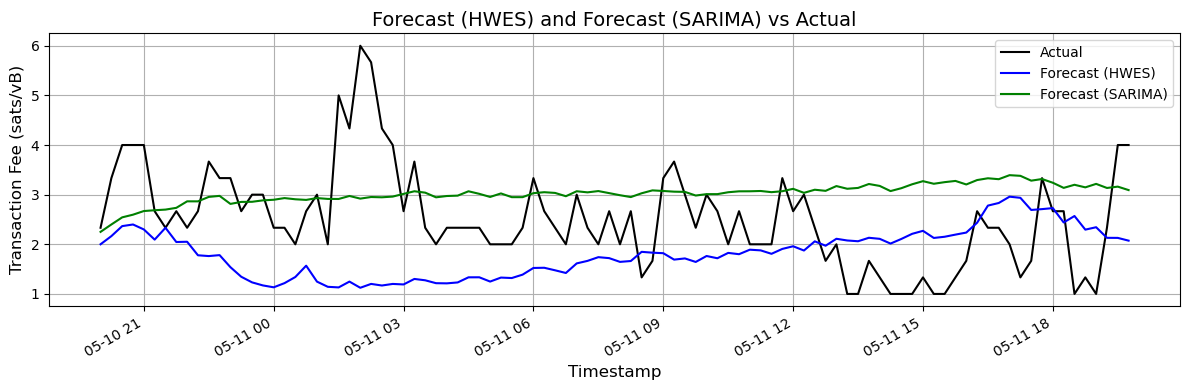

In [19]:
# HWES and SARIMA forecasts vs actual fee (test set)
fig, ax = plot_forecast_comparison(
    forecasts["HWES"], "Forecast (HWES)",
    forecasts["SARIMA"], "Forecast (SARIMA)"
)

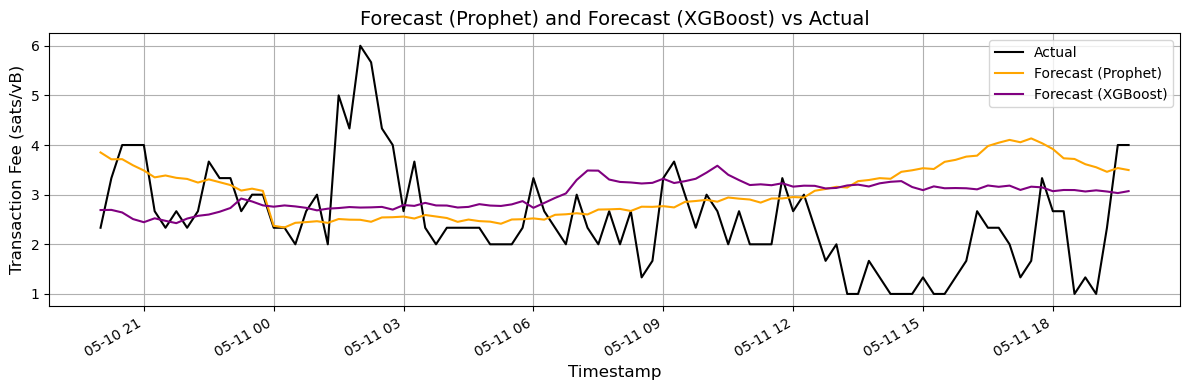

In [20]:
# Prophet and XGBoost forecasts vs actual fee (test set)
fig, ax = plot_forecast_comparison(
    forecasts["Prophet"], "Forecast (Prophet)",
    forecasts["XGBoost"], "Forecast (XGBoost)",
    color1="orange", color2="purple"
)

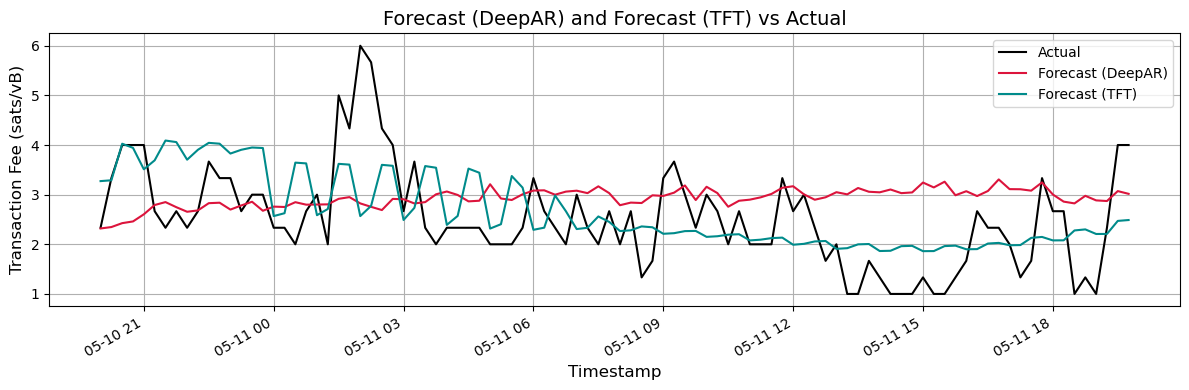

In [21]:
# DeepAR and TFT forecasts vs actual fee (test set)
fig, ax = plot_forecast_comparison(
    forecasts["DeepAR"], "Forecast (DeepAR)",
    forecasts["TFT"], "Forecast (TFT)",
    color1="crimson",     # DeepAR
    color2="darkcyan"     # TFT
)

### 4. Model-Specific Observations

In this final subsection, we interpret each model’s performance, using both numerical metrics and forecast plots. We focus on:

- **Where each model succeeds or fails** (e.g., smoothing vs. overreacting)
- **How they track trends, handle volatility, and anticipate spikes**
- **Tradeoffs observed in evaluation metrics** (e.g. accuracy vs. reactivity)

We also reflect on the alignment between each model’s architecture and its observed behavior under different fee conditions.

> **Note:** We have formulated detailed walkthrough and reasoning of the model preprocessing, experimentation, training, and evaluation steps for each model, please refer to companion notebook with link given in the respective subsections.



#### 4.1 HWES (Holt-Winters Exponential Smoothing)

HWES captures level and daily seasonality well but heavily smooths the signal, making it unable to react to abrupt fee spikes. It performs worst on deviation error and custom loss, despite yielding a decent RMSE.

Residual diagnostics from notebook further confirm its limitations: the residuals are heteroskedastic, autocorrelated, and non-normally distributed, indicating that meaningful structure remains unexplained.

- Captures daily cycle but ignores volatility and spike structure
- Residuals show non-random patterns → signal remains uncaptured
- Worst performance on custom loss among all learning-based models
- Serves as a seasonal benchmark, but lacks responsiveness

> For details, see [baseline_hwes.ipynb](baseline_hwes.ipynb)

#### 4.2 SARIMA (Seasonal ARIMA)

SARIMA improves on HWES by capturing temporal dependence and daily patterns, yielding better MAE and RMSE. However, it underperforms on custom loss and volatility-sensitive metrics, indicating difficulty in adapting to fast-changing fee dynamics.

- Captures autoregressive structure and daily trend
- Performs better than HWES on standard metrics (MAE, RMSE)
- Still underperforms on volatility-sensitive metrics, as it cannot anticipate sharp jumps

> For details, see [baseline_sarima.ipynb](baseline_sarima.ipynb)

#### 4.3 XGBoost

The XGBoost model outperformed classical baselines like HWES, SARIMA, and the median forecast on most standard accuracy metrics. By leveraging lagged fee history and congestion-based features, it delivered relatively stable and low-error predictions.

However, its forecasts remained overly smooth and failed to capture the sharp volatility spikes characteristic of the fee series. This is reflected in its relatively high deviation from actual standard deviation, signaling underfitting during periods of high variability.

- Strong on standard MAE metrics, indicating reliable overall trend modeling  
- Weak on volatility-sensitive metrics, with close forecasts that missed extreme events, which is also evident from MAPE, RMSE and forecast plots
- Lag and congestion features were still beneficial, but tree-based regularization limited responsiveness to abrupt changes


> For details, see [baseline_xgboost.ipynb](baseline_xgboost.ipynb)

#### 4.4 Prophet (Additive Time Series Decomposition)

Prophet is built for automated trend and seasonality modeling. It captures daily patterns reasonably well, but its strong trend assumptions lead to poor reactivity during sharp volatility.

- Automatically detects daily seasonality and extrapolates trend
- Performs moderately on standard metrics, but fails under high volatility
- Custom loss is high due to missed spikes and over-smoothed transitions

> For details, see [advanced_prophet.ipynb](advanced_prophet.ipynb)


#### 4.5 DeepAR (AutoRegressive RNN)

DeepAR models `fastestFee` using an autoregressive recurrent neural network (RNN) over multiple rolling windows. While it demonstrates some ability to capture volatility visually, it does not meaningfully outperform other models across key metrics. The forecasts remain overly smoothed and reactive rather than predictive.

- Marginal improvements over Prophet in RMSE and MAE, but not substantial
- Deviation-sensitive metrics still lag behind due to limited responsiveness to spikes
- Adds visual volatility in outputs, but lacks precision in spike timing or magnitude

> For details, see [advanced_deepar.ipynb](advanced_deepar.ipynb)

#### 4.6 Temporal Fusion Transformer (TFT)

The Temporal Fusion Transformer (TFT) combines attention mechanisms with recurrent encoders to capture both short-term dependencies and long-term patterns. It is the only model that consistently anticipates spike behavior in the `fastestFee` series, achieving the best performance across all metrics—especially custom loss and RMSE.

- Effectively models complex temporal dynamics and lagged external inputs
- Yields the lowest RMSE, MAPE, and custom loss among all models 
- Demonstrates robustness in both smooth and volatile periods

> For details, see [advanced_tft.ipynb](advanced_tft.ipynb)

## V. Final Insights & Future Work

Our evaluation demonstrates that the **Temporal Fusion Transformer (TFT)** consistently outperforms all other models, especially on volatility-sensitive metrics such as `custom_loss`, RMSE, and MAPE. Its ability to learn from temporal sequences and exogenous features makes it particularly effective for capturing sharp fluctuations in Bitcoin transaction fees.

Other key findings include:

- **XGBoost** outperforms all classical models, indicating that external features (e.g., mempool signals) add meaningful predictive power.
- **Prophet** and **HWES** consistently underperform on volatility-aware metrics due to their inherent smoothing behavior, which limits their responsiveness to spikes.
- **SARIMA** leverages autoregressive structure and daily seasonality more effectively than HWES, but still struggles with abrupt jumps.
- **DeepAR** is more expressive than classical models and capable of capturing non-linear patterns, but slightly lags behind TFT due to its lack of attention mechanisms and slower convergence.

While **TFT delivers the most accurate and reliable long-horizon forecasts**, it comes with higher training complexity and computational requirements. That said, our system is modular and extensible, allowing for further model experimentation and potential ensemble methods in future iterations.

However, some limitations remain:

- The dataset covers only two months, limiting exposure to rare but impactful market behaviors.
- Many key features—such as mempool congestion or block inclusion—are available only with a lag, reducing their value as leading indicators.
- Deep models like TFT require regular retraining and high computational resources, which may affect deployability.
- The custom loss function, while designed for volatility sensitivity, is static and could be further optimized or adapted over time.

Future directions include:

- **Expanding historical coverage** to improve generalization and capture infrequent fee dynamics.
- **Incorporating off-chain indicators**, such as network demand or exchange activity, to enrich the feature set.
- **Adapting the custom loss function** to dynamically adjust to volatility regimes and user priorities.
- **Developing hybrid pipelines**, where intermediate signals (e.g., mempool pressure) are predicted separately and used to inform the final fee forecast.
- **Exploring probabilistic forecasting and uncertainty estimation**, particularly once point accuracy improves.

This work establishes a strong foundation for more responsive and user-aligned transaction fee forecasting in real-world blockchain environments.